The purpose of this exercise was to use LDA on the data (without the labels) from Uri Goren's meetup, and try to match the topics to the original labels

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [19]:
import os, sys, re, collections, string, itertools
from operator import itemgetter as at
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
sys.path.append("../python")
import data
%matplotlib inline
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from gensim.models import Phrases
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
# SKLearn
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from ipywidgets import interact

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ishay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ishay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import os, re
import pandas as pd
from tqdm import tqdm
import pickle

def listTestFiles():
    """Returns a list of all test data in the data/ folder"""
    return [f for f in os.listdir("../data") if f.endswith(".txt") and f.split(".")[0].isdigit()]


def listFiles():
    """Returns a list of all training data in the data/ folder"""
    return [f for f in os.listdir("../data") if f.endswith(".txt") and f.find("-")>0]

def readFile(fname):
    """Given a file name `fname` or a list of filenames, returns its content"""
    if type(fname) == str:
        try:
            with open("../data/"+fname, 'rb') as f:
                data  = f.read().decode("utf8", "ignore")
        except:
            data = None
        return data
    elif type(fname) == list:
        return list(map(readFile, fname))
    else:
        raise TypeError("fname should be a string or a list of strings")

def getIterator():
    """Iterate over all training files amd get their content"""
    for fname in listFiles():
        tag = fname.split("-", 1)[0]
        yield tag, readFile(fname)

def asDataFrame(vectorizer=None, full_text=None, vocabulary=None):
    """
    Return a pandas DataFrame of all files,
    If a vectorizer function is passed, apply it on the textual data
    """
    ret = []
    if vectorizer is None:
        cols = ["num", "file", "tag"]
    else:
        cols = ["num", "vector", "tag"]
    for fname in tqdm(listFiles()):
        if fname.find("-")<0:
            continue
        tag, ind = fname.split("-", 1)
        if vectorizer is None:
            ret.append((int(ind.split(".", 1)[0]), fname, tag))
        else:
            ret.append((int(ind.split(".", 1)[0]), vectorizer(readFile(fname)), tag)) # full_text, vocabulary
    return pd.DataFrame(ret, columns=cols).set_index("num")

def preprocessed():
    """
    Return the training data and label, after replacing numbers with the <NUM> token, and removing non alpha numeric characters
    """
    X = []
    y = []
    digits = re.compile(r"\d[\d\.\$]*")
    not_allowed = re.compile(r"[^\s\w<>]")
    clean = lambda text: not_allowed.sub("", digits.sub("<NUM>",text.lower()))
    for fname in listFiles():
        tag, ind = fname.split("-", 1)
        body = clean(readFile(fname))
        y.append(tag)
        X.append(body)
    return (X,y)


def stemmed():
    """Apply Porter stemming on all documents in the training data, and return training data and label"""
    if os.path.exists("../data/stemmed_x.pickle"):
        with open("../data/stemmed_x.pickle", "rb") as f:
            X = pickle.load(f)
        with open("../data/stemmed_y.pickle", "rb") as f:
            y = pickle.load(f)
        return (X,y)
    import nltk
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    X = []
    y = []
    punc = re.compile(r"[\.,;\(\)\s]+")
    not_allowed = re.compile(r"[^\sa-z]")
    clean = lambda text: not_allowed.sub("", punc.sub(" ",text.lower()))
    for fname in tqdm(listFiles()):
        if fname.find("-")<0:
            continue
        tag, ind = fname.split("-", 1)
        body = clean(readFile(fname))
        body = " ".join([porter.stem(w) for w in body.split()])
        y.append(tag)
        X.append(body)
    with open("../data/stemmed_x.pickle", "wb") as f:
        pickle.dump(X, f)
    with open("../data/stemmed_y.pickle", "wb") as f:
        pickle.dump(y, f)
    return (X,y)


In [4]:
df = asDataFrame()
df.head()

100%|██████████████████████████████████████████████████████████████████████████| 4427/4427 [00:00<00:00, 555484.60it/s]


,file,tag
num,,
39500,bylaws-39500.txt,bylaws
39510,bylaws-39510.txt,bylaws
39520,bylaws-39520.txt,bylaws
39530,bylaws-39530.txt,bylaws
39540,bylaws-39540.txt,bylaws


In [5]:
df.shape

(4427, 2)

In [6]:
data_all = []
for index, row in tqdm_notebook(df.iterrows()):
    fname = row["file"]
    with open("../data/"+fname, 'rb') as f:
        data  = f.read().decode("utf8", "ignore")
        # Now replacing with num tokens
        digits = re.compile(r"\d[\d\$\%\.]*")
        data_no_digits = digits.sub("<NUM>", data)
        data_all.append(data_no_digits)

A Jupyter Widget

In [24]:
import joblib
joblib.dump(data_all, filename='lda_data_all')

['lda_data_all']

In [25]:
data_all=joblib.load('lda_data_all')

In [26]:
def my_analyzer(txt):
    return [stemmer.stem(w) for w in analyzer(txt)]

In [27]:
NUM_TOPICS = 6
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

In [28]:
stemmer = PorterStemmer()
def clean_text(text):
    """ Cleans the text: 1. tokenizing 2. stopwords 3. takes only words (no numbers or other chars) 4. stemming"""
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    stemmed_text = [stemmer.stem(w) for w in cleaned_text]
    return stemmed_text

In [29]:
sent = "I have dogs whose names are buffy"
clean_text(sent)

['dog', 'whose', 'name', 'buffi']

In [21]:
# For gensim we need to tokenize the data and filter out stopwords
from nltk import word_tokenize
tokenized_data = []
for text in tqdm_notebook(data_all):
    tokenized_data.append(clean_text(text))

A Jupyter Widget

In [30]:
joblib.dump(tokenized_data, filename='lda_tokenized_data')

KeyboardInterrupt: 

In [31]:
tokenized_data=joblib.load('lda_tokenized_data')

KeyboardInterrupt: 

In [32]:
tokenized_data[0][:10]

['exhibit',
 'num',
 'nightingal',
 'inc.',
 'form',
 'num',
 'file',
 'num',
 'num',
 'amend']

In [34]:
from gensim import models, corpora
# Build a Dictionary - association word to numeric id. Something like:
# 0: accord
# 1: accru
# 2: act
# and so on
dictionary = corpora.Dictionary(tokenized_data)
# It is a special dictionary with unique methods and attributes

In [42]:
dictionary[2]

'act'

In [44]:
len(dictionary)

25439

In [44]:
# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

In [45]:
# Have a look at how the 20th document looks like: [(word_id, count), ...]
print(corpus[20])

[(2, 1), (4, 1), (5, 2), (7, 2), (13, 8), (20, 10), (22, 7), (27, 7), (28, 2), (30, 2), (50, 5), (54, 2), (61, 7), (70, 2), (81, 1), (82, 1), (83, 1), (88, 5), (90, 3), (95, 1), (101, 3), (103, 1), (108, 6), (111, 6), (115, 2), (116, 1), (118, 1), (125, 1), (128, 1), (132, 7), (136, 5), (140, 2), (143, 38), (144, 1), (155, 2), (170, 1), (171, 1), (172, 1), (173, 3), (177, 2), (186, 1), (194, 2), (195, 1), (196, 1), (203, 1), (207, 1), (208, 1), (209, 8), (215, 4), (217, 2), (232, 1), (234, 2), (237, 1), (240, 1), (243, 1), (253, 1), (255, 1), (258, 1), (273, 1), (294, 1), (309, 1), (310, 7), (322, 1), (428, 1), (456, 2), (469, 1), (531, 1), (534, 1), (535, 1), (542, 4), (615, 1), (617, 1), (632, 1), (686, 1), (718, 3), (736, 1), (812, 3), (813, 1), (819, 1), (873, 1), (888, 3), (903, 1), (915, 1), (920, 1), (960, 1), (968, 1), (990, 1), (1009, 2), (1010, 3), (1022, 1), (1124, 1), (1127, 2), (1158, 1), (1188, 5), (1205, 1), (1268, 1), (1301, 1), (1382, 1), (1445, 1), (1471, 1), (1517, 2

In [46]:
# Build the LDA model
# corpus must come as bag of words
lda_model = models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

In [48]:
# print_topic is an attribute of LdaModel that shows the top words
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 12), "\n")

Topic #0: 0.046*"num" + 0.030*"shall" + 0.029*"share" + 0.019*"stock" + 0.017*"compani" + 0.016*"agreement" + 0.014*"purchas" + 0.013*"corpor" + 0.008*"may" + 0.008*"common" + 0.008*"date" + 0.007*"section" 

Topic #1: 0.040*"num" + 0.034*"compani" + 0.025*"agreement" + 0.019*"shall" + 0.019*"share" + 0.011*"date" + 0.010*"option" + 0.010*"purchas" + 0.009*"may" + 0.009*"stock" + 0.008*"optione" + 0.008*"secur" 

Topic #2: 0.062*"num" + 0.026*"agreement" + 0.024*"compani" + 0.022*"shall" + 0.014*"execut" + 0.014*"share" + 0.010*"date" + 0.009*"parti" + 0.009*"section" + 0.008*"may" + 0.008*"stock" + 0.006*"secur" 

Topic #3: 0.043*"num" + 0.031*"compani" + 0.023*"agreement" + 0.022*"employe" + 0.022*"shall" + 0.017*"employ" + 0.015*"restrict" + 0.013*"plan" + 0.013*"stock" + 0.013*"grante" + 0.012*"date" + 0.012*"termin" 

Topic #4: 0.053*"num" + 0.024*"agreement" + 0.019*"shall" + 0.016*"compani" + 0.014*"parti" + 0.014*"particip" + 0.013*"share" + 0.011*"stock" + 0.010*"execut" + 0.0

### 1. FInd the most probable topic for each document

In [67]:
# Now to examine each file
# For example I take one document and examine the probability of each topic
text_test = data_all[1300]
# bow counts the number of appearances from each word in a specific document 
bow = dictionary.doc2bow(clean_text(text_test))
prob_per_topic = lda_model[bow]
print(prob_per_topic)


[(2, 0.20614876), (3, 0.38506716), (4, 0.39647919), (5, 0.011497619)]


In [52]:
bow[:10]

[(0, 2),
 (3, 3),
 (5, 5),
 (8, 1),
 (12, 1),
 (13, 14),
 (14, 10),
 (15, 1),
 (17, 5),
 (18, 2)]

In [59]:
# finds the topic with the highest probability
max_prob = max([tup[1] for tup in prob_per_topic])
max_prob

0.41128525

In [60]:
prob_dict = dict(prob_per_topic)
prob_dict

{2: 0.19497466, 3: 0.38199535, 4: 0.41128525, 5: 0.01103999}

In [61]:
# finds the topic number
for key, value in prob_dict.items():
    if value == max_prob:
        print(key)

4


In [62]:
# Now everything together
topic_per_doc = []
for doc in tqdm_notebook(data_all):
    bow = dictionary.doc2bow(clean_text(doc))
    prob_per_topic = lda_model[bow]
    max_prob = max([tup[1] for tup in prob_per_topic])
    prob_dict = dict(prob_per_topic)
    for key, value in prob_dict.items():
        if value == max_prob:
            topic_per_doc.append(key)

A Jupyter Widget

In [63]:
joblib.dump(topic_per_doc, "lda_topic_per_doc")

['lda_topic_per_doc']

In [64]:
topic_per_doc = joblib.load("lda_topic_per_doc")

In [65]:
topic_series = pd.Series(topic_per_doc)
topic_series[:10]

0    0
1    2
2    0
3    2
4    0
5    2
6    2
7    2
8    2
9    2
dtype: int64

In [66]:
topic_series.value_counts()

3    1746
2    1297
5     792
0     390
4     139
1      63
dtype: int64

In [82]:
# This is based on a guess
trans_dict = {5: 'SPA', 2: 'bylaws', 0: 'credit', 3: 'employment', 1: 'rra', 4: 'rsu'}

In [83]:
topic_series_names = topic_series.map(trans_dict)

In [84]:
topic_series_names.index = df.index

In [85]:
df["pred"] = topic_series_names

In [86]:
df

,file,tag,0,pred
num,,,,
39500,bylaws-39500.txt,bylaws,Hi,credit
39510,bylaws-39510.txt,bylaws,Hi,bylaws
39520,bylaws-39520.txt,bylaws,Hi,credit
39530,bylaws-39530.txt,bylaws,Hi,bylaws
39540,bylaws-39540.txt,bylaws,Hi,credit
39550,bylaws-39550.txt,bylaws,Hi,bylaws
39560,bylaws-39560.txt,bylaws,Hi,bylaws
39570,bylaws-39570.txt,bylaws,Hi,bylaws
39580,bylaws-39580.txt,bylaws,Hi,bylaws


### 2. Find various possibilies per label (and ,atch topic to labels)

In [127]:
prob_per_doc = []
for doc in tqdm_notebook(data_all):
    bow = dictionary.doc2bow(clean_text(doc))
    prob_per_topic = lda_model[bow]
    tups_topics_probs = list(zip(*prob_per_topic))
    prob_doc = []
    for i in range(6):
        if i in tups_topics_probs[0]:
            prob = tups_topics_probs[1][tups_topics_probs[0].index(i)]
        else:
            prob = 0
        prob_doc.append(prob)
    prob_per_doc.append(prob_doc)

A Jupyter Widget

In [128]:
prob_matrix = pd.DataFrame(prob_per_doc)
prob_matrix

,0,1,2,3,4,5
0,0.999047,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.970465,0.000000,0.000000,0.023718
2,0.987822,0.000000,0.000000,0.000000,0.000000,0.010147
3,0.212139,0.000000,0.781961,0.000000,0.000000,0.000000
4,0.998570,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.979514,0.000000,0.000000,0.010923
6,0.053049,0.000000,0.940308,0.000000,0.000000,0.000000
7,0.038596,0.000000,0.953304,0.000000,0.000000,0.000000
8,0.178499,0.000000,0.816308,0.000000,0.000000,0.000000
9,0.030529,0.000000,0.958058,0.000000,0.000000,0.011263


In [130]:
tag_series = df.tag
tag_series.index = prob_matrix.index
prob_matrix["tags"] = tag_series

In [131]:
prob_matrix

,0,1,2,3,4,5,tags
0,0.999047,0.000000,0.000000,0.000000,0.000000,0.000000,bylaws
1,0.000000,0.000000,0.970465,0.000000,0.000000,0.023718,bylaws
2,0.987822,0.000000,0.000000,0.000000,0.000000,0.010147,bylaws
3,0.212139,0.000000,0.781961,0.000000,0.000000,0.000000,bylaws
4,0.998570,0.000000,0.000000,0.000000,0.000000,0.000000,bylaws
5,0.000000,0.000000,0.979514,0.000000,0.000000,0.010923,bylaws
6,0.053049,0.000000,0.940308,0.000000,0.000000,0.000000,bylaws
7,0.038596,0.000000,0.953304,0.000000,0.000000,0.000000,bylaws
8,0.178499,0.000000,0.816308,0.000000,0.000000,0.000000,bylaws
9,0.030529,0.000000,0.958058,0.000000,0.000000,0.011263,bylaws


In [132]:
prob_by_tag = prob_matrix.groupby("tags").mean().T

In [133]:
prob_by_tag

tags,SPA,bylaws,credit,employment,rra,rsu
0,0.306323,0.296676,0.022899,0.000955,0.302328,0.136625
1,0.165826,0.002195,0.006331,0.001758,0.072494,0.055874
2,0.444928,0.688103,0.809983,0.352874,0.610997,0.006942
3,0.004914,0.000000,0.001919,0.465128,0.000222,0.419945
4,0.073539,0.000000,0.149883,0.077616,0.007072,0.066325
5,0.002560,0.009580,0.004444,0.098679,0.005826,0.310466


C:\Users\ishay\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1694: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000135229C9BE0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000013522A15F98>], dtype=object)

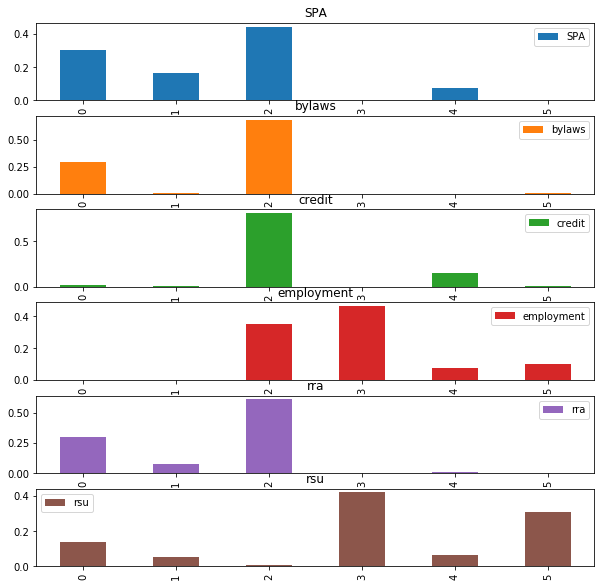

In [134]:
_, ax = plt.subplots(figsize=(10,10))
prob_by_tag.plot(kind='bar',subplots=True, ax=ax)

In [ ]:
# This is based on a guess
trans_dict = {5: 'SPA', 2: 'bylaws', 0: 'credit', 3: 'employment', 1: 'rra', 4: 'rsu'}

In [181]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [182]:
accuracy_score(df.tag, df.pred)

0.46871470521798059

One of my conclusions from this exercise is that the number of the LDA topics needs to be greater than that of the original labels, because normally there will be "garbage" topics, like number 2 here, that is relevant to all of the original labels.